In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import math
import string
import scipy.stats as stats
from tabulate import tabulate
from collections import defaultdict

In [2]:
pd.options.mode.copy_on_write = True
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

In [3]:
def load_wang_pi_data():
    df = pd.read_excel("./data/wang_raw_data_mutation_rate_literature_updating3.xlsx", sheet_name="gs_gt", 
                       header=0, usecols="A,E")
    df = df.rename(columns={"Species": "species"}) 
    df["species"] = df["species"].str.lower()
    return df

In [4]:
def load_bergeron_mut_rate_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 9", 
                       header=1, usecols="A,C,D,J,R,S", skiprows=0)
    df = df.rename(columns={
        "Species name": "species", 
        "Taxonomic group": "group",
        "Taxonomic order": "order",
        "Generation time (years)": "gen_time",
        "Average yearly mutation rate (m_yearly)": "u_year_non_modeled",
        "Modeled rate per generation (m_generation_modeled)": "u_modeled"})
    df["u_gen_non_modeled"] = df["gen_time"] * df["u_year_non_modeled"]
    primate_idx = (df["order"] == "Primate")
    df.loc[primate_idx, "group"] = "Primate"
    df = df.drop('order', axis=1)
    return df
    
def load_bergeron_CpG_frac_data():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 4", 
                       header=1, usecols="A,C:M", skiprows=0)
    # sum up column 2 to 11 (exclusive) to get total mutation count
    df["mutation count"] = df.iloc[:,2:11].sum(axis=1)
    df["perc_CpG>TpG"] = (df["% of all mutation in CpG"]/100) * (df["% of C > T in CpG"]/100) * 100
    df = df.rename(columns={"Species": "species"})
    df = df[["species", "perc_CpG>TpG", "mutation count"]]
    # drop last row because it is the total sum of mutations across all species
    df.drop(df.tail(1).index,inplace=True)
    df.loc[df["species"] == "Sphaerodactylus_macrolepis", "species"] = "Sphaerodactylus_inigoi"
    return df

def merge_bergeron_dfs():
    df_mu = load_bergeron_mut_rate_data()
    df_CpG = load_bergeron_CpG_frac_data()
    df_merge = pd.merge(df_CpG, df_mu, on=["species"])
    df_merge["u_CpG_gen_non_modeled"] = df_merge["u_gen_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    df_merge["u_CpG_year_non_modeled"] = df_merge["u_year_non_modeled"] * df_merge["perc_CpG>TpG"] / 100
    assert len(df_mu) == len(df_CpG) and len(df_mu) == len(df_merge)
    print(f"In total {len(df_merge)} species in Bergeron's dataset with mutation rate estimates, {df_merge['u_modeled'].isna().sum()} does not have a modeled per-generation mutation rate")
    df_merge["species"] = df_merge["species"].str.lower()
    return df_merge

def convert_wang_df_species_name(df):
    # Wang's species name are not delimited by '_'
    df["species"] = df.apply(lambda x: "_".join(x["species"].split(" ")), axis=1)
    # 2 species name have a mismatch
    w2b_map = {
        'gallus_gallus_domesticus': 'gallus_gallus', 
        'tupaia_chinensis_belangeri': 'tupaia_belangeri'
    }
    df = df.replace({"species": w2b_map})
    return df
    
def check_bergeron_wang_species(df_b, df_w):
    '''helper function to check that the species names in bergeron's dataset match that of wang's'''
    species_b = set(df_b["species"])
    species_w = set(df_w["species"])
    assert len(species_b - species_w) == 0
    
def merge_wang_bergeron_dfs():
    df_b = merge_bergeron_dfs()
    df_w = load_wang_pi_data()
    df_w_species_update = convert_wang_df_species_name(df_w)
    check_bergeron_wang_species(df_b, df_w_species_update)
    print(df_b.columns, df_w.columns)
    df_merge = pd.merge(df_b, df_w_species_update, on=["species"])
    assert len(df_merge) == len(df_b)
    print(f"After merging Wang and Bergeron's dataset, there are {len(df_merge)} species")
    return df_merge

def calculate_Ne(df):
    """
        this helper function first filters out species with 0 diveristy, 
        and then calculates the Ne using Ne = pi/(4 * mu)
    """
    # num_zero_diversity = np.count_nonzero(df_merge["diversity"] == 0)
    # species_zero_diversity = set(df_merge.loc[(df_merge['diversity'] == 0)]["species"])
    df_div = df[df['diversity'] != 0]
    print(f"after filtering out species with 0 diversity, there are now {len(df_div)} species")
    df_div["Ne"] = df_div["diversity"] / (4 * df_div["u_gen_non_modeled"])
    df_div["Ne*g"] = df_div["Ne"] * df_div["gen_time"]
    return df_div

In [5]:
def plot_color_gradients(cmap_name, ax):
    """helper function, given a cmap name, visualize its color gradient"""
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    ax.imshow(gradient, aspect='auto', cmap=matplotlib.colormaps[cmap_name])
    ax.set_axis_off()

def get_color_index(num_groups, group_name_index):
    """Calculate an decimal index between (0.05, 1)"""
    return 1 - (0.05+ (1-0.05) / num_groups * group_name_index)

def plot_regression(df, group_name2idx_map, colors, x_df_key, y_df_key, x_ax_label, y_ax_label, ax=None, label_fontsize=15):
    """
        helper function to generate relevant regression plots, 
        x_df_key: key of the dataframe column plotted on the x-axis (typically Ne or Ne * g),
        y_df_key: key of the dataframe column plotted on the y-axis (typically per-gen or per-year mutation rate), 
        x_ax_label: label on the x-axis
        y_ax_label: label on the y-axis
    """
    if ax is None:
        fig, ax = plt.subplots()
        
    # due to renaming to stay consistent with phylogenetic tree
    df_human = df.loc[df.index[df["species"] == "homo_sapiens"]]
    human_ne, human_mu = df_human[x_df_key].to_numpy()[0], df_human[y_df_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "mus_musculus"]]
    mice_ne, mice_mu = df_mice[x_df_key].to_numpy()[0], df_mice[y_df_key].to_numpy()[0]
    ax.scatter(human_ne, human_mu, color=colors[group_name2idx_map["Primate"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_ne, mice_mu, color=colors[group_name2idx_map["Mammal"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    offset_factor=1.1
    ax.text(offset_factor * human_ne, offset_factor * human_mu, "human", zorder=float("inf"), fontsize=15)
    ax.text(offset_factor * mice_ne, offset_factor * mice_mu, "mouse", zorder=float("inf"), fontsize=15)

    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group"] == gn]]
        ax.scatter(df_gn[x_df_key], df_gn[y_df_key], color=colors[idx], label=gn)
    
    ax.set_xscale("log")
    ax.set_yscale("log")
    
    ax.set_xlabel(x_ax_label, fontsize=label_fontsize, weight="bold")
    ax.set_ylabel(y_ax_label, fontsize=label_fontsize, weight="bold")
    ax.tick_params(axis='both', which='major', labelsize=label_fontsize)
    
    # grid line
    ax.grid(which="major", linestyle = "dashed")
    ax.set_axisbelow(True)

In [71]:
## helper functions to plot data generated from R

def load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.7, 0.85), fontsize=15, log_scale=True, ax=None, 
                                      label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    df = pd.read_csv(r_filename)
    intercept = df["intercept"].to_numpy()[0]
    slope = df["slope"].to_numpy()[0]
    p_val_slope = df["slope.p"].to_numpy()[0]
    if log_scale is True:
        plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                         label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
    else:
        plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=text_pos, fontsize=fontsize, p_value=p_val_slope, ax=ax, 
                                            label=label, linestyle=linestyle, linewidth=linewidth, alpha=alpha, color=color)
        
    return [intercept, slope]
    
def plot_regression_line_on_linearscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                        label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axline((0, intercept), slope=slope, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)
    
def plot_regression_line_on_logscale(intercept, slope, x_bounds, text_pos=(0.7, 0.85), fontsize=15, p_value=None, ax=None, 
                                     label=None, linestyle="dashed", linewidth=1, alpha=1, color="black"):
    if ax is None:
        fig, ax = plt.subplots()
    y = np.power(10, intercept) * np.power(x_bounds, slope)
    ax.plot(x_bounds, y, linestyle=linestyle, linewidth=linewidth, label=label, alpha=alpha, color=color)
    if p_value:
        p_val_str = f"{p_value:.2f}" if p_value > 0.05 else f"{p_value:.1e}"
        text = f"slope: {slope:.3f}\np-value: {p_val_str}"
    else:
        text = f"slope: {slope:.3f}"
    ax.text(text_pos[0], text_pos[1], text, transform=ax.transAxes, fontsize=fontsize)

In [8]:
df_merge = merge_wang_bergeron_dfs()
df_merge.to_csv("./output/csv/df_bergeron_no_ne.csv")
df_div = calculate_Ne(df_merge)
df_div.to_csv("./output/csv/df_bergeron_ne.csv")

In total 68 species in Bergeron's dataset with mutation rate estimates, 13 does not have a modeled per-generation mutation rate
Index(['species', 'perc_CpG>TpG', 'mutation count', 'group', 'gen_time',
       'u_year_non_modeled', 'u_modeled', 'u_gen_non_modeled',
       'u_CpG_gen_non_modeled', 'u_CpG_year_non_modeled'],
      dtype='object') Index(['species', 'diversity'], dtype='object')
After merging Wang and Bergeron's dataset, there are 68 species
after filtering out species with 0 diversity, there are now 62 species


In [6]:
color_map_name = "nipy_spectral"
cmap = matplotlib.colormaps[color_map_name]  
vertebrate_group_name2idx_map = {
    "Primate": 0, 
    "Mammal": 1, 
    "Bird": 2,
    "Reptile": 3,
    "Fish": 4
} 

num_groups = len(vertebrate_group_name2idx_map)
colors = [cmap(get_color_index(num_groups, i)) for i in range(num_groups)]

## DBH plots for overall mutation rate with Bergeron's data

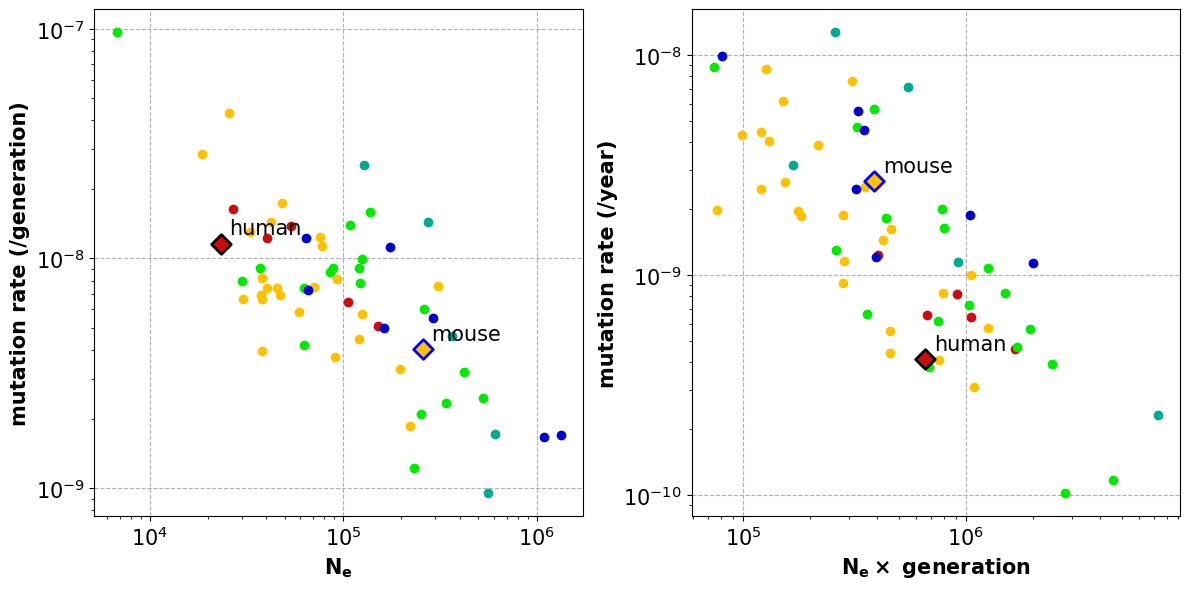

In [8]:
def generate_dbh_plot_overall_mutation_rate(df, group_name2idx_map):
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    x1_label, y1_label = r"$\bf{N_e}$", "mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_gen_non_modeled", x1_label, y1_label, ax=ax[0])
    x2_label, y2_label = r"$\bf{N_e} \times$ generation", "mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_year_non_modeled", x2_label, y2_label, ax=ax[1])
generate_dbh_plot_overall_mutation_rate(df_div, vertebrate_group_name2idx_map)

## Regress mutation rate (total and CpG) on generation time g

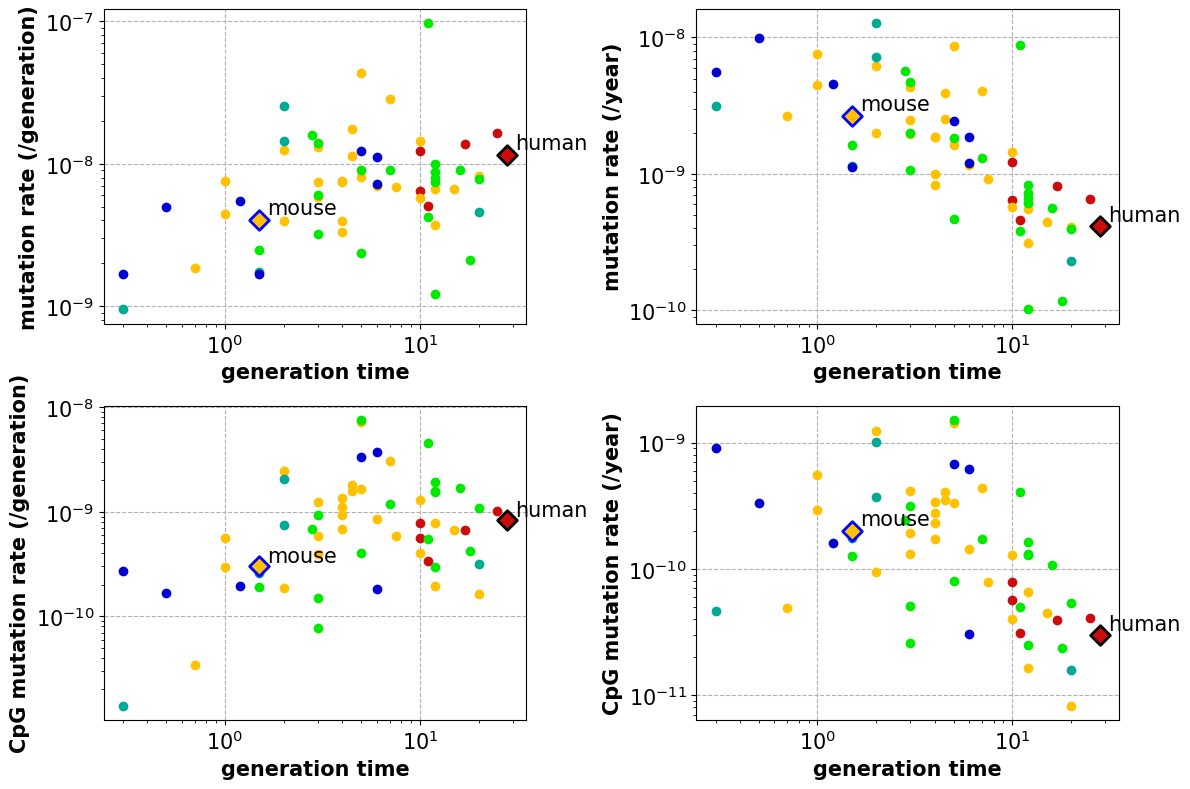

In [9]:
def generate_mu_vs_g_plots(df, group_name2idx_map):
    fig, ax = plt.subplots(2, 2, figsize=(12,8))
    x1_label, y1_label = "generation time", "mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_gen_non_modeled", x1_label, y1_label, ax=ax[0,0])
    x2_label, y2_label = "generation time", "mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_year_non_modeled", x2_label, y2_label, ax=ax[0,1])

    # CpG mutation rate
    x3_label, y3_label = "generation time", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_CpG_gen_non_modeled", x3_label, y3_label, ax=ax[1,0])
    x4_label, y4_label = "generation time", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_CpG_year_non_modeled", x4_label, y4_label, ax=ax[1,1])
    
generate_mu_vs_g_plots(df_div, vertebrate_group_name2idx_map)

### Only total yearly mutation rate vs generation time

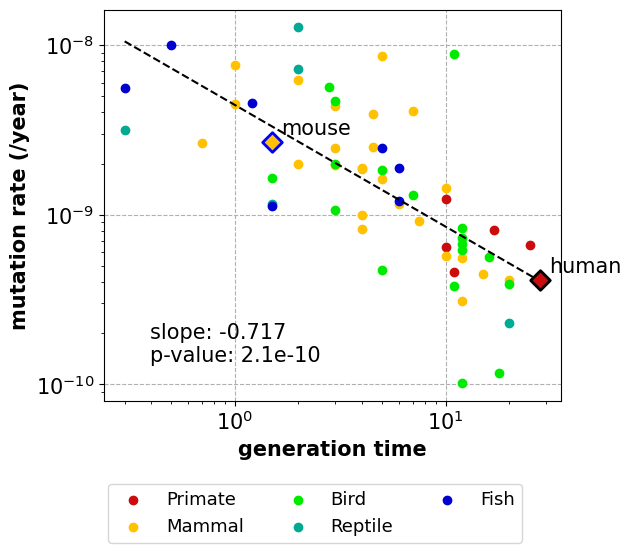

In [10]:
)
    
def yearly_mutation_rate_gen_time(df, group_name2idx_map, save_figure=False):
    x_label, y_label = "generation time", "mutation rate (/year)"
    fig, ax = plt.subplots()
    plot_regression(df, group_name2idx_map, colors, "gen_time", "u_year_non_modeled", x_label, y_label, ax=ax)
    r_filename = f"./output/r_bergeron/mu_year_gen.csv"
    gen_time = df["gen_time"]
    x_bounds = [np.min(gen_time), np.max(gen_time)]
    load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.1, 0.1), ax=ax)
    
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0), fontsize=13, ncol=3)
    fig.tight_layout()
    if save_figure:
        fig.savefig("figures/yearly_mut_rate_vs_gen_time_bergeron.pdf", bbox_inches='tight')
    
yearly_mutation_rate_gen_time(df_div, vertebrate_group_name2idx_map)

## DBH plots for CpG mutation rate

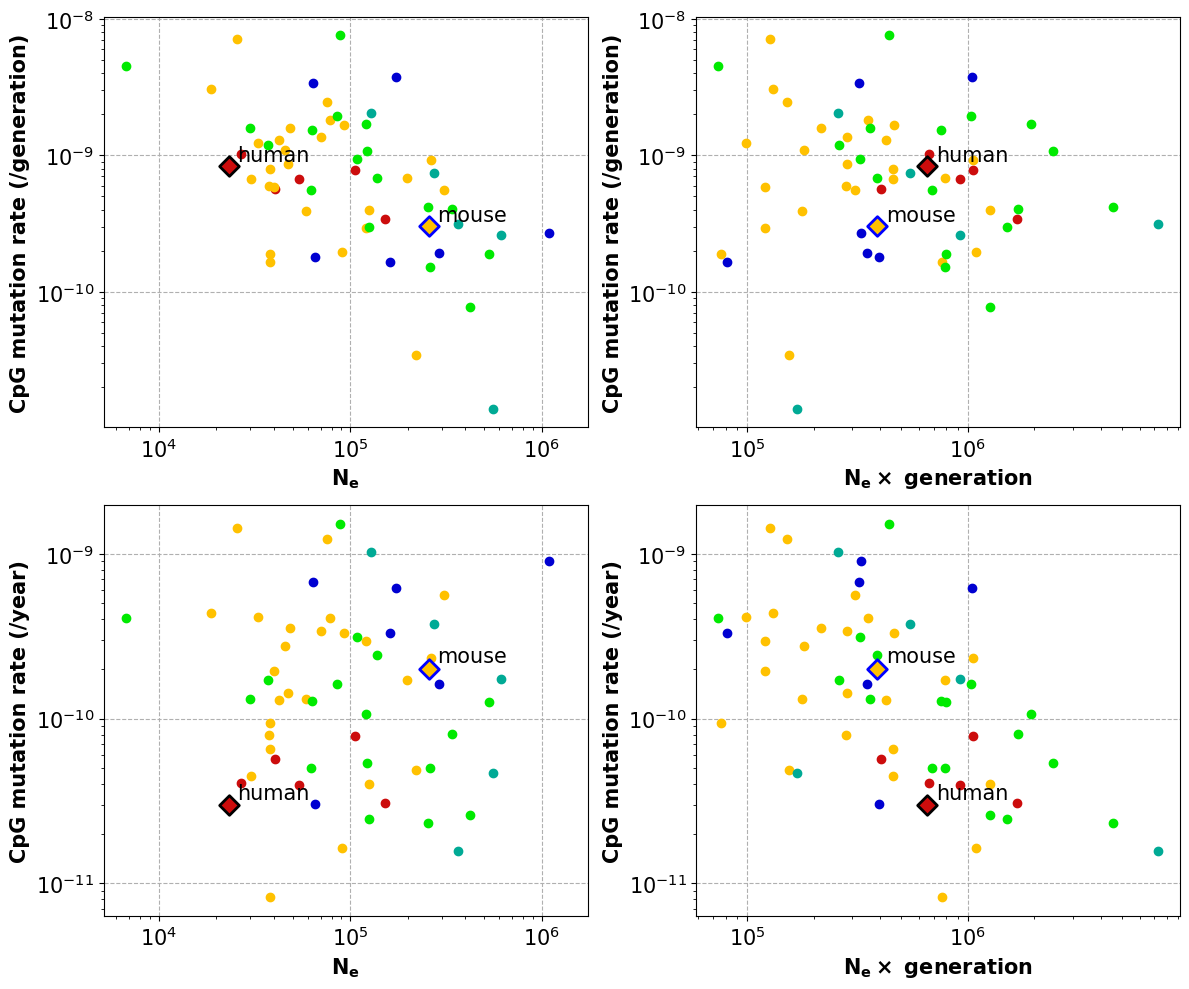

In [11]:
def generate_dbh_plot_CpG_mutation_rate(df, group_name2idx_map):
    fig, ax = plt.subplots(2, 2, figsize=(12,10))
    x1_label, y1_label = r"$\bf{N_e}$", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_CpG_gen_non_modeled", x1_label, y1_label, ax=ax[0,0])
    
    x2_label, y2_label = r"$\bf{N_e} \times$ generation", "CpG mutation rate (/generation)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_CpG_gen_non_modeled", x2_label, y2_label, ax=ax[0,1])
    
    x3_label, y3_label = r"$\bf{N_e}$", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne", "u_CpG_year_non_modeled", x3_label, y3_label, ax=ax[1,0])
    
    x4_label, y4_label = r"$\bf{N_e} \times$ generation", "CpG mutation rate (/year)"
    plot_regression(df, group_name2idx_map, colors, "Ne*g", "u_CpG_year_non_modeled", x4_label, y4_label, ax=ax[1,1])
generate_dbh_plot_CpG_mutation_rate(df_div, vertebrate_group_name2idx_map)

## Regression of proportion of mutation subtypes vs generation time

In [12]:
def compute_percentage_of_mutation_subtypes():
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 4", 
                       header=1, usecols="A:M", skiprows=0)
    # sum up column 2 to 11 (exclusive) to get total mutation count
    df = df.rename(columns={"Species": "species", "Group": "group"})
    df["mutation_count"] = df.iloc[:,2:11].sum(axis=1)
    df["C>A_%"] = (df["C > A noCpG_x000D_"] + df["C > A CpG_x000D_"]) / df["mutation_count"] * 100
    df["C>G_%"] = (df["C > G noCpG"] + df["C > G CpG"]) / df["mutation_count"] * 100
    df["C>T_CpG_%"] = df["C > T CpG"] / df["mutation_count"] * 100
    df["C>T_noCpG_%"] = df["C > T noCpG"] / df["mutation_count"] * 100
    df["A>C_%"] = df["A > C"] / df["mutation_count"] * 100
    df["A>G_%"] = df["A > G"] / df["mutation_count"] * 100
    df["A>T_%"] = df["A > T"] / df["mutation_count"] * 100
    df = df[["species", "group", "C>A_%", "C>G_%", "C>T_CpG_%", "C>T_noCpG_%", "A>C_%", "A>G_%", "A>T_%", "mutation_count"]]
    assert np.allclose(df[["C>A_%", "C>G_%", "C>T_CpG_%", "C>T_noCpG_%", "A>C_%", "A>G_%", "A>T_%"]].to_numpy().sum(axis=1), 100 * np.ones(len(df)))
    # the last row is the sum of all data
    df.drop(df.tail(1).index,inplace=True)
    return df
    
def load_bergeron_generation_time():
    col_names = ["species", "Common name", "group", "order", "Generation time"]
    # U: Unicode string, f: floating point
    data_types = {"species": 'U', "Common name": 'U', "group": 'U', "order": 'U', "Generation time": 'f'}
    df = pd.read_excel("./data/bergeron_raw_data.xlsx", sheet_name="Supplementary Table 9", 
                       header=None, names=col_names, dtype=data_types, usecols="A:D,J", skiprows=2)
    # change the species name inigoi to macrolepis to match species name in supplementary table #4 (CpG data)
    # both are dwarf gecko
    df.loc[df["species"] == "Sphaerodactylus_inigoi", "species"] = "Sphaerodactylus_macrolepis"
    return df

def merge_mutation_rate_generation_time_dataframe_and_remove_zero_count_species(min_mutation_count=0, remove_zero_count=True, save_data=True):
    def assert_matching_df_keys(df1, df2):
        keys1 = set(df1.apply(lambda x: str(x["species"]) + "_" + str(x["group"]), axis=1))
        keys2 = set(df2.apply(lambda x: str(x["species"]) + "_" + str(x["group"]), axis=1))
        assert len(keys1 - keys2) == 0 and len(keys1) == len(keys2) 
    df = compute_percentage_of_mutation_subtypes()
    df_gen_time = load_bergeron_generation_time()
    assert_matching_df_keys(df, df_gen_time)

    df_merge = pd.merge(df, df_gen_time, on=["species", "group"])
    # primates were originally annotated as mammals in the species column
    primate_idx = (df_merge["order"] == "Primate")
    df_merge.loc[primate_idx, "group"] = "Primate"
    assert len(df_merge) == len(df)

    df_filter_by_count = df_merge.loc[df_merge["mutation_count"] > min_mutation_count] 
    print(f"after filtering by minimum count of {min_mutation_count}, reduced {len(df_merge)} species to {len(df_filter_by_count)}")
    
    mutation_types = ["C>A_%", "C>G_%", "C>T_noCpG_%", "C>T_CpG_%", "A>T_%", "A>G_%", "A>C_%"]
    for mt in mutation_types:
        df_type = df_filter_by_count[["species", "group", "Generation time", mt]]
        if remove_zero_count:
            df_type = df_type.loc[df_type[mt] > 0]
            print(f"there are {len(df_type)} species with >0 {mt[:-2]} mutations")
        if save_data:
            df_type.to_csv(f"./output/mutation_subtype_vs_gen_time/csv/{mt}.csv")

    df_all_nonzero = df_filter_by_count[(df_filter_by_count != 0).all(1)]
    print(f"there are {len(df_all_nonzero)} species with at least 1 mutation for all mutation subtypes")
    if save_data:
        df_all_nonzero.to_csv(f"./output/mutation_subtype_vs_gen_time/csv/all.csv")
    
merge_mutation_rate_generation_time_dataframe_and_remove_zero_count_species(min_mutation_count=10, remove_zero_count=True, save_data=True)

after filtering by minimum count of 10, reduced 68 species to 61
there are 56 species with >0 C>A mutations
there are 56 species with >0 C>G mutations
there are 61 species with >0 C>T_noCpG mutations
there are 61 species with >0 C>T_CpG mutations
there are 52 species with >0 A>T mutations
there are 60 species with >0 A>G mutations
there are 49 species with >0 A>C mutations
there are 40 species with at least 1 mutation for all mutation subtypes


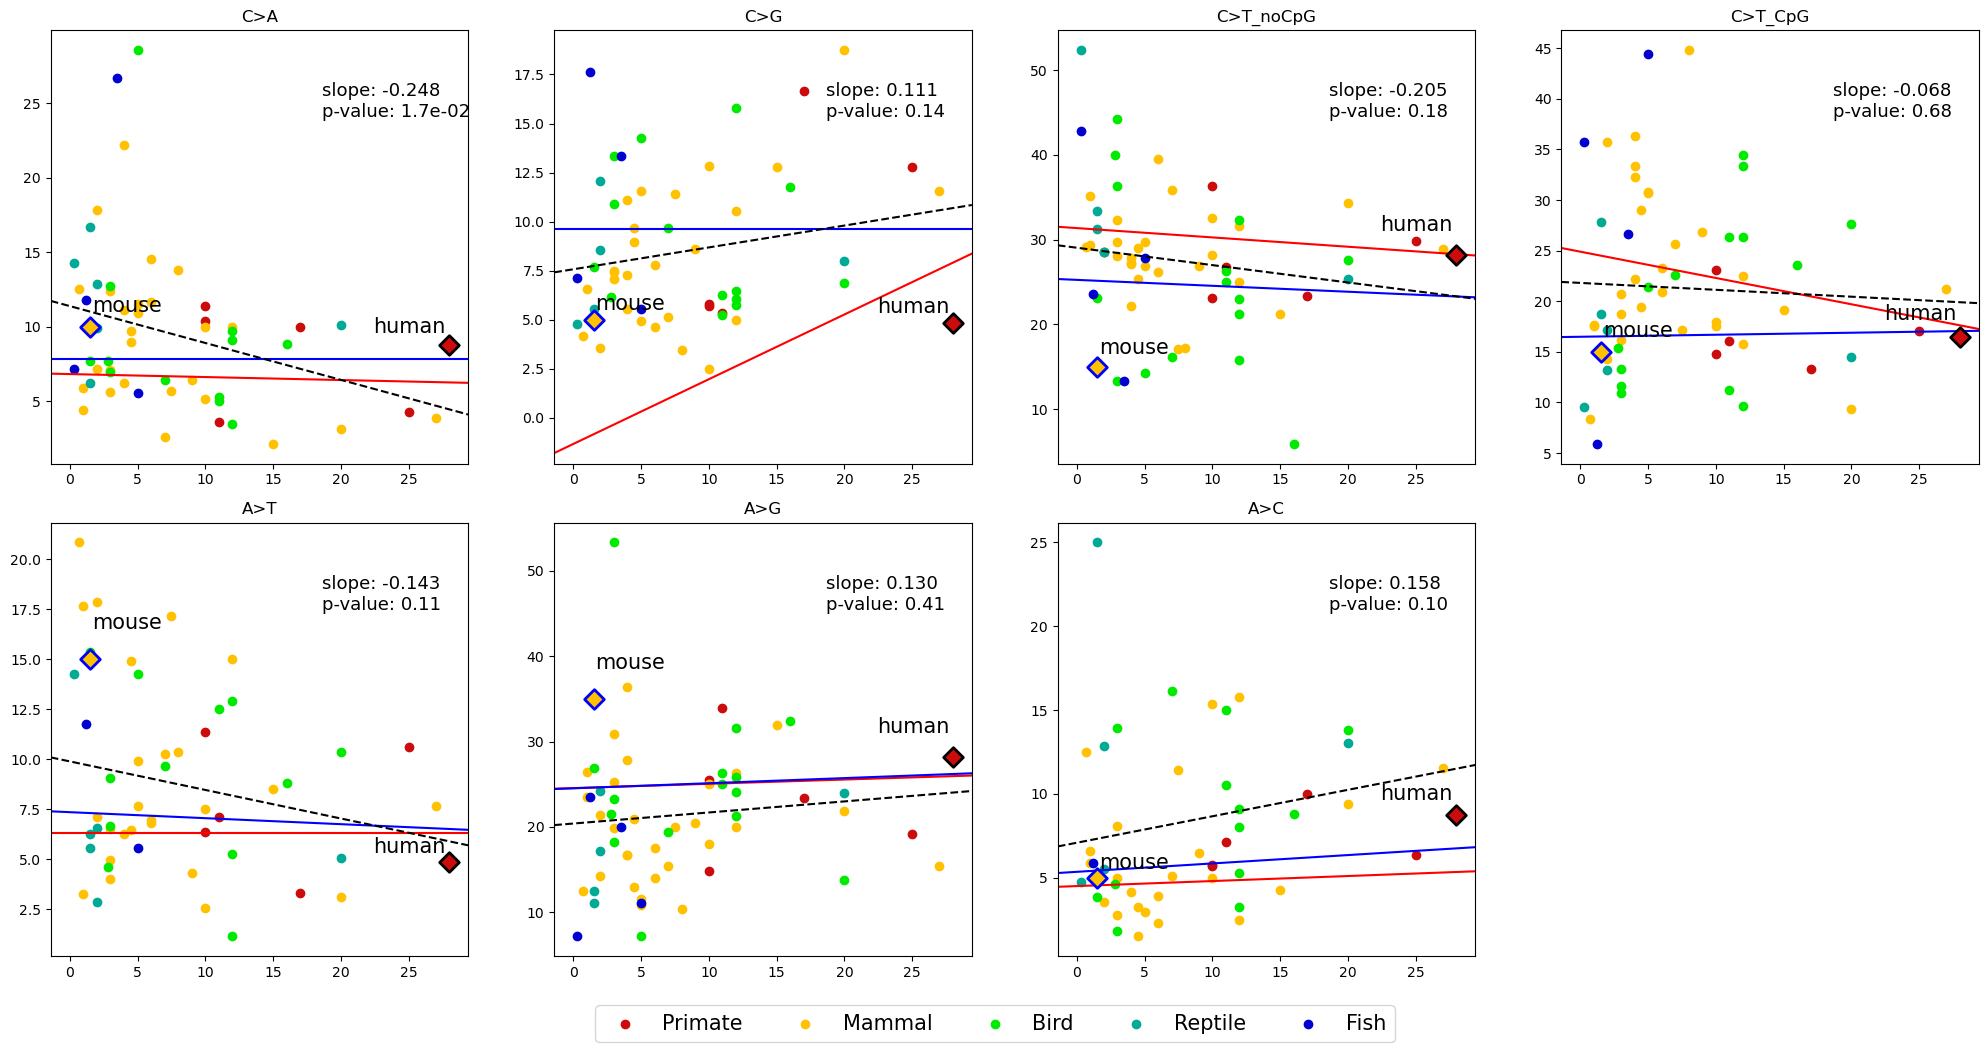

In [13]:
# supp table 11
# row 1: intercept, row 2: slope, col 1: maternal, col 2: paternal
CA_j, CG_j, CT_j, CT_CpG = [[6.82, 6.82+1.04],[-0.02, 0]], [[-1.33, -1.33+10.94],[0.33, -0.0]], [[31.36, 31.36-6.11],[-0.11, -0.07]], [[24.89, 24.89-8.41],[-0.26, 0.02]]
# reverse complement from T -> A
AT_j, AG_j, AC_j = [[6.32, 6.32+1.04],[-0, -0.03]], [[24.54, 24.54-0.03],[0.05, 0.06]], [[4.50, 4.50+0.85],[0.03, 0.05]]
jonsson_data = np.array([CA_j, CG_j, CT_j, CT_CpG, AT_j, AG_j, AC_j])

def plot_jonsson_data(data, ax):
    # first row intercept, second row slope
    # maternal
    ax.axline((0, data[0,0]), slope=data[1,0], c="red") #, linestyle = 'dashed') 
    # paternal
    ax.axline((0, data[0,1]), slope=data[1,1], c="blue") 
    
def plot_helper(df, x_df_key, y_df_key, group_name2idx_map, colors, ax, type_label, fontsize=15):
    df_human = df.loc[df.index[df["species"] == "Homo_sapiens"]]
    human_x, human_y = df_human[x_df_key].to_numpy()[0], df_human[y_df_key].to_numpy()[0]
    df_mice = df.loc[df.index[df["species"] == "Mus_musculus"]]
    mice_x, mice_y = df_mice[x_df_key].to_numpy()[0], df_mice[y_df_key].to_numpy()[0]
    ax.scatter(human_x, human_y, color=colors[group_name2idx_map["Primate"]], 
               marker='D', edgecolor="black", s=100, lw=2, zorder=float("inf")) #label="human"
    ax.scatter(mice_x, mice_y, color=colors[group_name2idx_map["Mammal"]], 
               marker='D', edgecolor="blue", s=100, lw=2, zorder=float("inf")) #label="mice"
    ax.text(0.8 * human_x, 1.1 * human_y, "human", zorder=float("inf"), fontsize=fontsize)
    ax.text(1.1 * mice_x, 1.1 * mice_y, "mouse", zorder=float("inf"), fontsize=fontsize)
    # ax.set_ylim(0, 60)

    for idx, gn in enumerate(group_name2idx_map.keys()):
        df_gn = df.loc[df.index[df["group"] == gn]]
        ax.scatter(df_gn[x_df_key], df_gn[y_df_key], color=colors[idx], label=gn)
    ax.set_title(type_label[:-2])
    
def plot_rate_vs_gen_time(group_name2idx_map, colors, jonsson_data):
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    mutation_types = ["C>A_%", "C>G_%", "C>T_noCpG_%", "C>T_CpG_%", "A>T_%", "A>G_%", "A>C_%"]
    for idx, mt in enumerate(mutation_types):
        df = pd.read_csv(f"./output/mutation_subtype_vs_gen_time/csv/{mt}.csv")
        r, c = idx // 4, idx % 4
        plot_helper(df, "Generation time", mt, group_name2idx_map, colors, ax[r,c], mt, fontsize=15)
        plot_jonsson_data(jonsson_data[idx], ax[r,c])
        r_filename = f"./output/mutation_subtype_vs_gen_time/r_output/{mt[:-2]}.csv"
        load_and_plot_r_regression_output(r_filename, [0,30], log_scale=False, fontsize=13, text_pos=(0.65, 0.8), ax=ax[r,c])
    fig.delaxes(ax[1,3])

    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,0), ncol=5, fontsize=15) #bbox_transform=fig.transFigure)
    fig.tight_layout()
    
plot_rate_vs_gen_time(vertebrate_group_name2idx_map, colors, jonsson_data)

## Reproductive longevity model
The classical reproductive longetivity model assumes that the per-generation mutation load can be modelled as follows:
$\mu_{\textit{gen}} = B + M(g - p)$ where $B$ is the pre-puberty mutation load, and $M$ is the post-puberty annual mutation load, $g$ is generation time and $p$ is age at puberty. It is assumed that both $B$ and $M$ are constants across species. In human $B=6.35\times 10^{-9}$ and $M=3.5\times 10^{-10}$. In mice, $B=3.75\times 10^{-9}$ and $M=1.64\times 10^{-9}$. The annual mutation rate therefore can be estimated as follows:
$\mu_{\textit{year}} = \frac{B}{g} + M(1-P)$$ where $P=\frac{p}{g}$, this was estimated to be 0.419 using mammalian data.

In the relaxed model, we assume that $B=b\cdot g^{\beta}$ and $M = m \cdot g^{\alpha}$. It is estimated that $(m, \alpha) = (1.24\times 10^{-9}, -0.413)$ and $(b, \beta) = (4.0\times 10^{-9}, 0.126)$. The annual mutation rate therefore is modelled as follows:
$\mu_{\textit{year}} = b\cdot g^{\beta-1} + m\cdot g^{\alpha}(1-P)$.


-----------  -----------------  ----------------  --------
             longevity (human)  longevity (mice)  flexible
rss (u_gen)  1.08E-14           1.21E-14          1.10E-14
-----------  -----------------  ----------------  --------


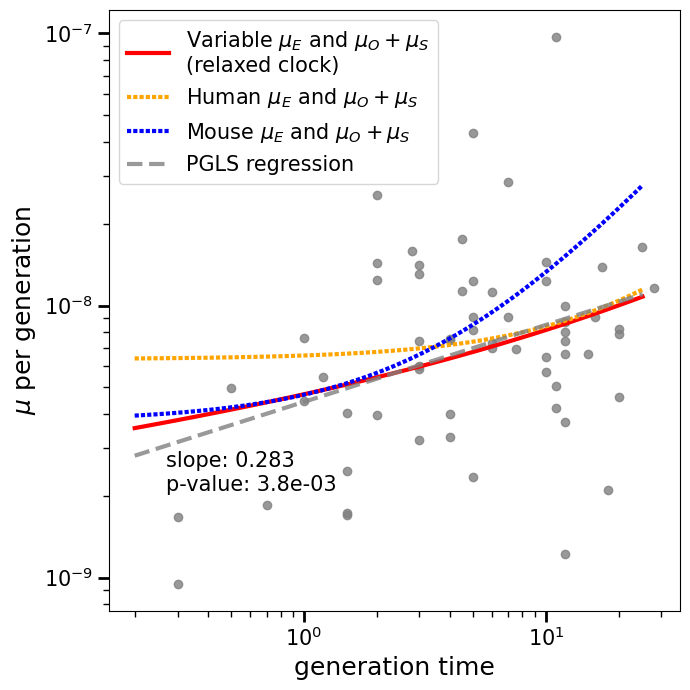

In [73]:
# Dog, Goat, Guinea pig, Siamese fighting fish, Common carp, Domestic cat, Chicken, House mouse, Pig, Alpaca
domesticated_list = ["canis_lupus_familiaris", "capra_hircus", "cavia_aperea", "betta_splendens", "cyprinus_carpio", "felis_catus", "gallus_gallus", "mus_musculus", "sus_scrofa", "vicugna_pacos"]

def plot_u_gen_vs_generation_time_helper(g, u_gen_longevity, u_gen_longevity_mice, u_gen_relaxed, ax):
    ax.plot(g, u_gen_longevity, label="longevity model human")
    ax.plot(g, u_gen_longevity_mice, label="longevity model mice")
    # ax.plot(g, u_gen_longevity_est, label="longevity model estimated")
    ax.scatter(df["gen_time"], df["u_gen_non_modeled"])
    ax.plot(g, u_gen_relaxed, linewidth=3, label="relaxed model")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("generation time", fontsize=15)
    ax.set_ylabel("mu (/generation)", fontsize=15)
    ax.legend()

def compute_residual_sum_of_squares(y_obs, y_pred):
    return np.sum(np.square(y_obs - y_pred))

def u_gen_longevity_fn(B, M, P):
    def f(generation_time):
        return B + M * (generation_time - P * generation_time)
    return f
    
def u_year_longevity_fn(B, M, P):
    def f(generation_time):
        return (B + M * (generation_time - P * generation_time)) / generation_time
    return f

def u_gen_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)
    return f
    
def u_year_relaxed_fn(b, beta, m, alpha, P):
    def f(generation_time):
        return (b * generation_time ** (beta) + m * generation_time ** (alpha) * (generation_time - P * generation_time)) / generation_time
    return f
    
def plot_longevity_model_prediction_per_generation(df, save_figure=False):
    B_h, M_h = 6.35 * 10**(-9), 3.5 * 10**(-10)
    B_m, M_m = 3.75 * 10**(-9), 1.64 * 10**(-9)
    # B_est, M_est = 8.67946E-09, 3.23132E-10
    P = 0.419

    m, alpha = 1.24 * 10 ** (-9), -0.413
    b, beta = 4.0 * 10 ** (-9), 0.126
    
    g = np.logspace(-0.7, 1.4)
    u_gen_longevity_human = u_gen_longevity_fn(B_h, M_h, P)
    u_gen_longevity_mice = u_gen_longevity_fn(B_m, M_m, P)
    u_gen_relaxed = u_gen_relaxed_fn(b, beta, m, alpha, P) #b * g ** (beta) + m * g ** (alpha) * (g - P * g)

    g_df = df["gen_time"].to_numpy()
    rss_gen = []
    for u in [u_gen_longevity_human, u_gen_longevity_mice, u_gen_relaxed]:
        rss_gen.append(compute_residual_sum_of_squares(df["u_gen_non_modeled"].to_numpy(), u(g_df)))

    rss_table_output = [["", "longevity (human)", "longevity (mice)", "flexible"], ["rss (u_gen)"] + [f"{x:.2E}" for x in rss_gen]]
    print(tabulate(rss_table_output))
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    linewidth = 3
    ax.scatter(df["gen_time"], df["u_gen_non_modeled"], alpha=0.8, color="gray")
    ax.plot(g, u_gen_relaxed(g), color="red", linewidth=linewidth, label="Variable $\mu_E$ and $\mu_O+\mu_S$ \n(relaxed clock)")
    ax.plot(g, u_gen_longevity_human(g), color="orange", linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Human $\mu_E$ and $\mu_O+\mu_S$")
    ax.plot(g, u_gen_longevity_mice(g), color="blue", linewidth=linewidth, linestyle=(0, (1, 0.5)), label=r"Mouse $\mu_E$ and $\mu_O+\mu_S$")

    gen_time = df["gen_time"]
    x_bounds = [np.min(gen_time), np.max(gen_time)]
    r_filename = f"./output/r_bergeron/mu_gen_gen.csv"
    load_and_plot_r_regression_output(r_filename, [g[0], g[-1]], text_pos=(0.1, 0.2), ax=ax, 
                                      label="PGLS regression", linestyle="dashed", linewidth=linewidth, alpha=0.8, color="gray")
    
    axis_label_font_size, tick_label_font_size, legend_font_size = 18, 15, 15
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.tick_params(axis='both', which='major', labelsize=tick_label_font_size, width=2, length=8)
    ax.tick_params(axis='both', which='minor', width=1, length=4)
    ax.set_xlabel("generation time", fontsize=axis_label_font_size)
    ax.set_ylabel(r"$\mu$ per generation", fontsize=axis_label_font_size)
    ax.legend(fontsize=legend_font_size)
    
    if save_figure:
        fig.savefig("figures/figure2_longevity_model.pdf", bbox_inches='tight')
    
def plot_longevity_model_prediction(df, label_domestication=False, domesticated_list=None):
    B_h, M_h = 6.35 * 10**(-9), 3.5 * 10**(-10)
    B_m, M_m = 3.75 * 10**(-9), 1.64 * 10**(-9)
    B_est, M_est = 8.67946E-09, 3.23132E-10
    P = 0.419

    m, alpha = 1.24 * 10 ** (-9), -0.413
    b, beta = 4.0 * 10 ** (-9), 0.126
    
    g = np.logspace(-0.8, 1.4)
    u_gen_longevity_human = u_gen_longevity_fn(B_h, M_h, P)
    u_gen_longevity_mice = u_gen_longevity_fn(B_m, M_m, P)
    u_gen_relaxed = u_gen_relaxed_fn(b, beta, m, alpha, P) #b * g ** (beta) + m * g ** (alpha) * (g - P * g)
    
    u_year_longevity_human = u_year_longevity_fn(B_h, M_h, P)
    u_year_longevity_mice = u_year_longevity_fn(B_m, M_m, P)
    u_year_relaxed = u_year_relaxed_fn(b, beta, m, alpha, P)

    g_df = df["gen_time"].to_numpy()
    rss_gen = []
    for u in [u_gen_longevity_human, u_gen_longevity_mice, u_gen_relaxed]:
        rss_gen.append(compute_residual_sum_of_squares(df["u_gen_non_modeled"].to_numpy(), u(g_df)))

    rss_year = []
    for u in [u_year_longevity_human, u_year_longevity_mice, u_year_relaxed]:
        rss_year.append(compute_residual_sum_of_squares(df["u_year_non_modeled"].to_numpy(), u(g_df)))
    rss_table_output = [["", "longevity (human)", "longevity (mice)", "flexible"], ["rss (u_gen)"] + [f"{x:.2E}" for x in rss_gen], ["rss (u_year)"] + [f"{x:.2E}" for x in rss_year]]
    print(tabulate(rss_table_output))
        
    fig, ax = plt.subplots(1, 2, figsize=(15,7))
    if label_domestication:
        domestication_mask = df["species"].isin(domesticated_list)
        for i in range(2):
            df_temp = df[domestication_mask] if i == 0 else df[~domestication_mask]
            label = "domesticated" if i == 0 else "non-domesticated"
            ax[0].scatter(df_temp["gen_time"], df_temp["u_gen_non_modeled"], label=label)
            ax[1].scatter(df_temp["gen_time"], df_temp["u_year_non_modeled"], label=label)
    else:
        ax[0].scatter(df["gen_time"], df["u_gen_non_modeled"])
        ax[1].scatter(df["gen_time"], df["u_year_non_modeled"])
        
        
    ax[0].plot(g, u_gen_longevity_human(g), label=r"Human $\mu_E$ and $\mu_O+\mu_S$")
    ax[0].plot(g, u_gen_longevity_mice(g), label=r"Mouse $\mu_E$ and $\mu_O+\mu_S$")
    ax[0].plot(g, u_gen_relaxed(g), linewidth=3, label="Variable $\mu_E$ and $\mu_O+\mu_S$ (relaxed clock)")

    ax[1].plot(g, u_year_longevity_human(g), label="longevity model human")
    ax[1].plot(g, u_year_longevity_mice(g), label="longevity model mice")
    ax[1].plot(g, u_year_relaxed(g), linewidth=3.0, label="relaxed model")
    
    gen_time = df["gen_time"]
    x_bounds = [np.min(gen_time), np.max(gen_time)]
    r_filename = f"./output/r_bergeron/mu_year_gen.csv"
    load_and_plot_r_regression_output(r_filename, x_bounds, text_pos=(0.1, 0.1), ax=ax[1], label="PGLS regression")
    
    legend_fontsize = 14

    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_xlabel("generation time", fontsize=15)
    ax[0].set_ylabel(r"$\mu$ per generation", fontsize=15)
    ax[0].legend(fontsize=legend_fontsize)
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].set_xlabel("generation time", fontsize=15)
    ax[1].set_ylabel(r"$\mu$ per year", fontsize=15)
    ax[1].legend(fontsize=legend_fontsize)
    
    
def estimate_B_M_from_u_gen(u_gen, gen):
    result = stats.linregress(gen, u_gen)
    P = 0.419
    slope, intercept = result.slope, result.intercept
    B = intercept
    M = slope / (1-P)
    print(f"B = {B:2G}, M = {M:2G}")
    poly = np.poly1d([slope, intercept])
    print(intercept, slope, intercept + slope * 25)
    
    fig, ax = plt.subplots()
    ax.scatter(gen, u_gen)
    ax.plot(gen, poly(gen))
    
# plot_longevity_model_prediction(df_div, label_domestication=False, domesticated_list=domesticated_list)
plot_longevity_model_prediction_per_generation(df_div, save_figure=True)

B = 8.67946E-09, M = 3.23132E-10
8.679462007192371e-09 1.8773985719766357e-10 1.337295843713396e-08


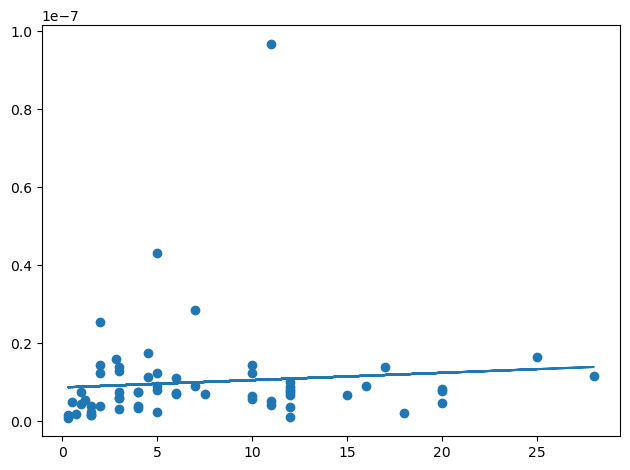

In [15]:
estimate_B_M_from_u_gen(df_div["u_gen_non_modeled"], df_div["gen_time"])

## Compare log scale vs linear scale data

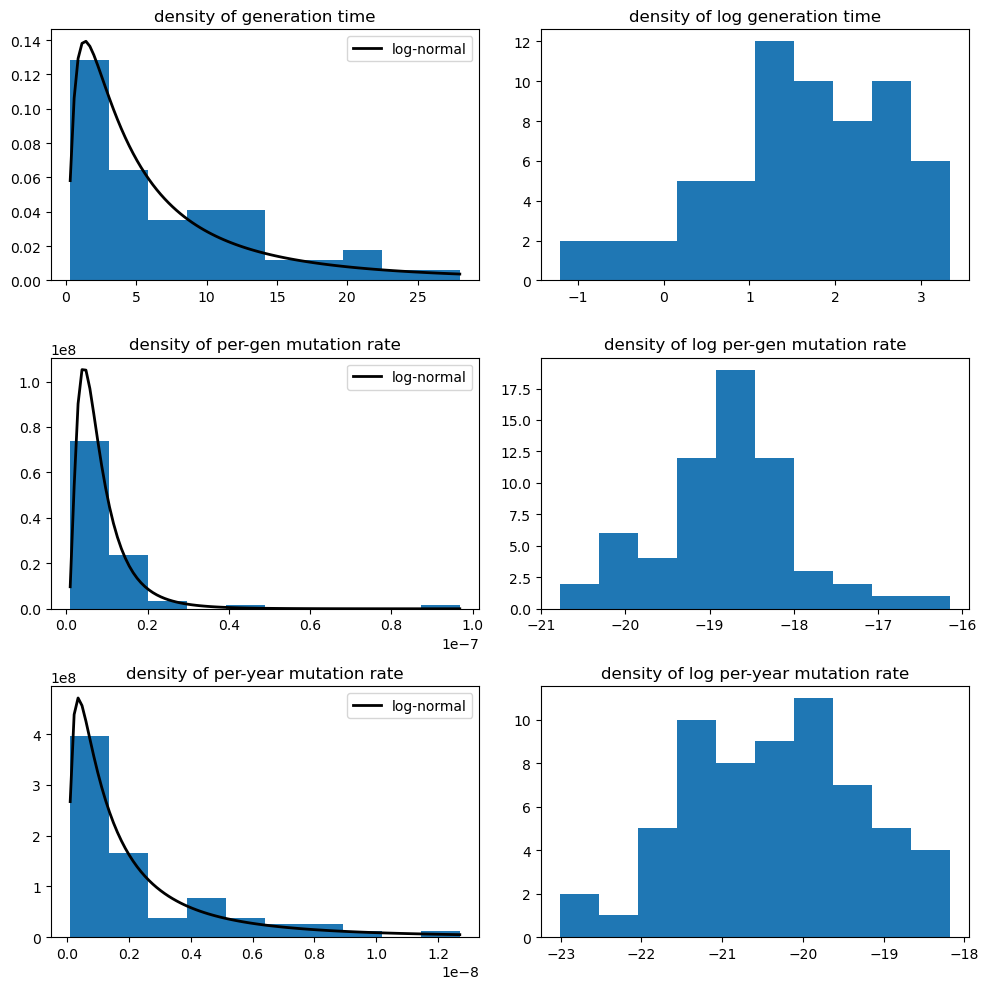

In [18]:
def calculate_lognorm_params(input):
    # https://stackoverflow.com/questions/8870982/how-do-i-get-a-lognormal-distribution-in-python-with-mu-and-sigma
    s, scale = np.var(input), np.exp(np.mean(input))
    rv = stats.lognorm(s, scale=scale)
    return [s, scale, rv]
    
def plot_data_distribution(df):
    gen = df["gen_time"].to_numpy()
    x_gen = np.linspace(np.min(gen), np.max(gen), 100)
    log_gen = np.log(gen)
    [_, _, rv_gen] = calculate_lognorm_params(log_gen)
    
    mu_g = df["u_gen_non_modeled"].to_numpy()
    x_mu_g = np.linspace(np.min(mu_g), np.max(mu_g), 100)
    log_mu_g = np.log(mu_g)
    [_, _, rv_mu_g] = calculate_lognorm_params(log_mu_g)
    
    mu_y = df["u_year_non_modeled"].to_numpy()
    x_mu_y = np.linspace(np.min(mu_y), np.max(mu_y), 100)
    log_mu_y = np.log(mu_y)
    [_, _, rv_mu_y] = calculate_lognorm_params(log_mu_y)
    
    fig, ax = plt.subplots(3,2, figsize=(10,10))
    ax[0,0].hist(gen, density=True)
    ax[0,0].plot(x_gen, rv_gen.pdf(x_gen), 'k-', lw=2, label="log-normal")
    ax[0,0].legend()
    ax[0,0].set_title("density of generation time")
    ax[0,1].hist(log_gen)
    ax[0,1].set_title("density of log generation time")
    
    ax[1,0].hist(mu_g, density=True)
    ax[1,0].plot(x_mu_g, rv_mu_g.pdf(x_mu_g), 'k-', lw=2, label="log-normal")
    ax[1,0].legend()
    ax[1,0].set_title("density of per-gen mutation rate")
    ax[1,1].hist(log_mu_g)
    ax[1,1].set_title("density of log per-gen mutation rate")

    ax[2,0].hist(mu_y, density=True)
    ax[2,0].plot(x_mu_y, rv_mu_y.pdf(x_mu_y), 'k-', lw=2, label="log-normal")
    ax[2,0].legend()
    ax[2,0].set_title("density of per-year mutation rate")
    ax[2,1].hist(log_mu_y)
    ax[2,1].set_title("density of log per-year mutation rate")
    
    fig.tight_layout()
plot_data_distribution(df_div)